In [1]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Utility functions

def rmse(x, y):
    """
    Returns root mean square error between two vectors x and y.
    """
    return np.sqrt(np.mean(np.square(x - y)))


def compare_rmse(states, measurements, filtered_states):
    """
    Returns the rmse error for both measurements and filtered states.
    """
    meas_error = rmse(states, measurements)
    filt_error = rmse(states, filtered_states)
    return meas_error, filt_error


def plot_results(time_steps, states, measurements, filtered_states, filtered_covs, idx):
    """
    Plot the results of filtering.
    """
    plt.figure(figsize=(10,5))
    plt.plot(time_steps, states, '+-', label="Signal")
    plt.plot(time_steps, measurements, '.-', label="Measurements")
    plt.plot(time_steps, filtered_states, label="Filtered states")
    plt.fill_between(time_steps, 
                    filtered_states - filtered_covs,
                    filtered_states + filtered_covs,
                    alpha=0.33, 
                    color="b")
    plt.xlabel("Time step")
    plt.title(f"Trajectory number {idx}.")
    plt.legend()
    plt.show()

In [3]:
# The Extended Kalman Filter

def ekf_update(m, P, y):
    """
    An ekf update step.
    The current mean and covariance are passed in.
    Only works for a 1d problem.
    """
    # Prediction step
    pred_m = dyn_fun(m)
    pred_P = P * der_dyn_fun(m)**2 + Q

    # Update step
    S = pred_P * der_meas_fun(pred_m)**2 + R
    K = pred_P * der_meas_fun(pred_m) / S
    new_m = pred_m + K * (y - meas_fun(pred_m))
    new_P = pred_P - S * K**2

    return new_m, new_P


def filter_routine(initial_guess, initial_guess_cov, update_method,
                   observations):
    T = observations.shape[0]
    x = initial_guess
    cov = initial_guess_cov

    states = np.empty(T)
    covariances = np.empty(T)

    for i, y in enumerate(observations):
        x, cov = update_method(x, cov, y)
        states[i] = x
        covariances[i] = cov

    return states, covariances

In [4]:
# The state space model

def dyn_fun(x):
    """
    The dynamic model function.
    """
    return x - 0.01 * math.sin(x)


def der_dyn_fun(x):
    """
    The derviative of the dynamic model funtion.
    """
    return 1 - 0.01 * math.cos(x)


def meas_fun(x):
    """
    The measurement model function.
    """
    return 0.5 * np.sin(2 * x)


def der_meas_fun(x):
    """
    The derivative of the measurement model function.
    """
    return math.cos(2 * x)


def gen_trajectory(initial_guess, initial_guess_cov, Q, R, num_time_steps):
    """
    Returns the state and measurements of for a single trajectory.
    """
    # Sample initial state
    x_0 = np.random.normal(loc=initial_guess, scale=math.sqrt(initial_guess_cov))

    # Generate noises (this is faster than generating them one by one)
    q = np.random.normal(scale=math.sqrt(Q), size=num_time_steps)
    r = np.random.normal(scale=math.sqrt(R), size=(num_time_steps + 1))

    # Simulate the trajectory
    states = [x_0]

    for k in range(100):
        # Get the next state
        x_k = states[-1]
        x_k = dyn_fun(x_k) + q[k]
        states.append(x_k)
        
    states = np.array(states)

    # Get the measurements
    measurements = meas_fun(states) + r

    return states, measurements

# Define the needed parameters
m_0, P_0 = 0., 0.0001
Q = 0.0001
R = 0.02
num_time_steps = 100
time_steps = np.arange(num_time_steps + 1)

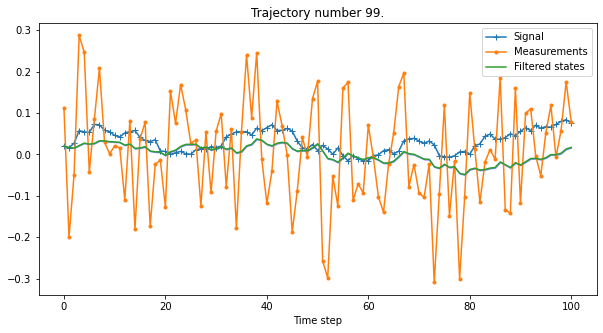

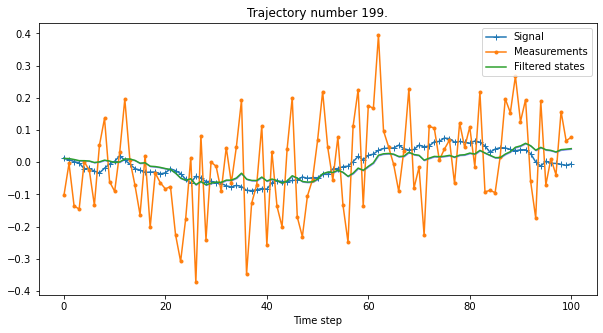

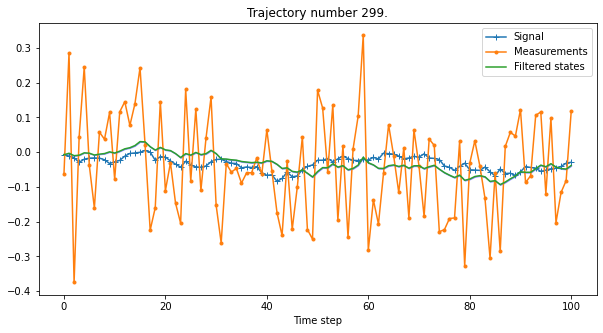

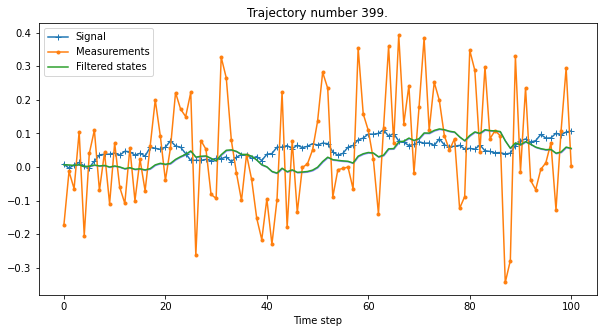

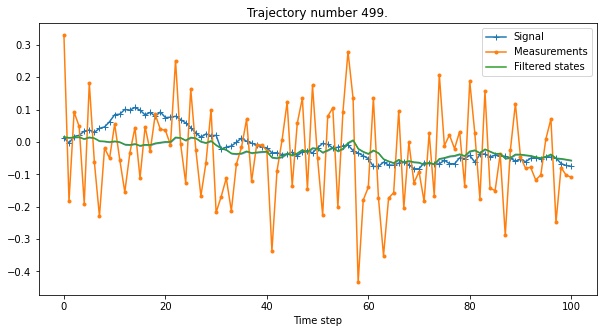

In [5]:
# Simulating 500 trajectories
num_trajectories = 500
rmse_vals = np.empty((num_trajectories, 2))

for i in range(num_trajectories):
    states, measurements = gen_trajectory(m_0, P_0, Q, R, num_time_steps)
    filtered_states, filtered_covs = filter_routine(states[0], P_0, ekf_update, measurements)
    meas_error, filt_error = compare_rmse(states, measurements, filtered_states)
    rmse_vals[i] = np.array([meas_error, filt_error])
    
    if i % 100 == 99:
        plot_results(time_steps, states, measurements, filtered_states, filtered_covs, idx=i)

In [6]:
print(rmse_vals[10:20])

[[0.11917839 0.0324545 ]
 [0.1580487  0.03821633]
 [0.12719586 0.03822365]
 [0.13956357 0.0283745 ]
 [0.13284783 0.02489869]
 [0.12898459 0.03952047]
 [0.13643628 0.03620068]
 [0.1354469  0.02155221]
 [0.13769463 0.03948349]
 [0.14951508 0.02690771]]


In [7]:
print(np.mean(rmse_vals, 0))

[0.14109677 0.03154248]
